# **Algoritma *K-Means***

## **Pengertian *K-Means Clustering***

*K-Means Clustering*  adalah teknik pengelompokan data yang memisahkan data ke dalam cluster, mengelompokkan data dengan fitur yang sama bersama-sama dan mengelompokkan data dengan karakteristik yang berbeda ke dalam kelompok yang berbeda dengan centroid sebagai acuannya. Metode k-means membagi data menjadi beberapa kelompok sehingga data dengan karakteristik yang sama berada pada cluster yang sama dan data dengan karakteristik yang berbeda berada pada cluster yang berbeda


## **Manfaat *Clustering***


- Clustering merupakan metode segmentasi data yang sangat berguna dalam prediksi dan analisa masalah bisnis tertentu. Misalnya Segmentasi pasar, marketing dan pemetaan zonasi wilayah.
- Identifikasi obyek dalam bidang berbagai bidang seperti computer vision dan image processing.

Hasil clustering yang baik akan menghasilkan tingkat kesamaan yang tinggi dalam satu kelas dan tingkat kesamaan yang rendah antar kelas. Kesamaan yang dimaksud merupakan pengukuran secaranumeric terhadap dua buah objek. Nilai kesamaan antar kedua objek akan semakin tinggi jika kedua objek yang dibandingkan memiliki kemiripan yang tinggi. Begitu juga dengan sebaliknya. Kualitas hasil clustering sangat bergantung pada metode yang dipakai

## **Inertia (Sum Square error/SSE)**


Dalam konteks algoritma *K-Means Clustering*, *inertia* (Sum Square error/SSE) adalah salah satu metrik evaluasi untuk menilai seberapa baik data dikelompokkan ke dalam klaster serta mengukur jumlah total jarak kuadrat antara setiap titik data dan pusat klaster (centroid) tempat titik tersebut.

Inertia didefinisikan sebagai:

$$
\text{Inertia} = \sum_{i=1}^{n} \left\| x_i - \mu_{c_i} \right\|^2
$$

**Penjelasan Notasi**
- $x_i$: Titik data ke-$i$
- $\mu_{c_i}$: Centroid dari klaster tempat $x_i$ berada
- $\left\| x_i - \mu_{c_i} \right\|^2$: Jarak Euclidean kuadrat antara $x_i$ dan centroid-nya
- $n$: Jumlah total data

## **Silhouette Analysis**


Silhouette Analysis adalah metrik evaluasi lain yang lebih baik dari inertia dalam banyak kasus untuk mengevaluasi hasil clustering, seperti pada K-Means, karena mempertimbangkan dua hal sekaligus yaitu:

- Kepadatan dalam klaster

- Jarak antar klaster

Silhouette Analysis mengukur seberapa mirip suatu titik data dengan klasternya sendiri dibandingkan dengan klaster terdekat lainnya. Rumusnya adalah:

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

**Penjelasan Notasi**:
- $a(i)$: Rata-rata jarak dari titik $i$ ke semua titik lain dalam klaster yang sama (cohesion)
- $b(i)$: Rata-rata jarak dari titik $i$ ke semua titik dalam klaster terdekat yang bukan miliknya (separation)
- $s(i)$: Skor silhouette untuk titik $i$, dengan nilai antara -1 dan 1

Nilai skor $s(i)$ ditafsirkan sebagai berikut:
- Jika $s(i) \approx 1$, maka titik berada jauh dari klaster lain dan cocok dengan klasternya
- Jika $s(i) \approx 0$, maka titik berada di antara dua klaster
- Jika $s(i) \approx -1$, maka titik bisa jadi salah masuk klaster

Untuk mengevaluasi seluruh hasil clustering, digunakan rata-rata dari semua $s(i)$:

$$
S = \frac{1}{n} \sum_{i=1}^{n} s(i)
$$

- $n$: Jumlah total data
- $S$: Silhouette score rata-rata seluruh data


## **Implementasi dengan menggunakan data Iris**

In [77]:
%pip install pymysql
%pip install psycopg2

## **Library yang digunakan**

In [78]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
import psycopg2
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display, HTML

## **Pengumpulan Data**

In [79]:
def get_pg_data():
    conn = psycopg2.connect(
        host="postgresqltest-projectadzin.i.aivencloud.com",
        user="avnadmin",
        password="AVNS_k58rpi0pi31N8ucX-vK",
        database="defaultdb",
        port=16209
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM sepal")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]  # Ambil nama kolom
    cursor.close()
    conn.close()

    return pd.DataFrame(data, columns=columns)

def get_mysql_data():
    conn = pymysql.connect(
        host="mysql-386c0068-projectadzin.l.aivencloud.com",
        user="avnadmin",
        password="AVNS_-Zr6_we8osFXobQb3qi",
        database="iris",
        port=16209
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM petal")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]  # Ambil nama kolom
    cursor.close()
    conn.close()

    return pd.DataFrame(data, columns=columns)

# Ambil data dari kedua database
df_postgresql = get_pg_data()
df_mysql = get_mysql_data()

# Gabungkan berdasarkan kolom 'id' dan 'Class'
df_merged = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")

# Cetak semua data hasil gabungan tanpa indeks
display(HTML(df_merged.to_html(index=False)))

id,class,petal_length,petal_width,sepal_length,sepal_width
1,Iris-setosa,1.4,0.2,5.1,3.5
2,Iris-setosa,14.0,2.0,40.9,30.0
3,Iris-setosa,1.3,0.2,4.7,3.2
4,Iris-setosa,15.0,2.5,46.0,31.0
5,Iris-setosa,1.4,0.2,5.0,3.6
6,Iris-setosa,1.7,0.4,5.4,3.9
7,Iris-setosa,1.4,0.3,4.6,3.4
8,Iris-setosa,1.5,0.2,5.0,3.4
9,Iris-setosa,1.4,0.2,4.4,2.9
10,Iris-setosa,1.5,0.1,4.9,3.1


## **Clustering pada data Iris menggunakan K-Means dengan jumlah cluster 2,3 dan 4**

In [80]:
# 1. Siapkan fitur (X) dan label (y)
feature_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = df_merged[feature_cols].values
y = df_merged['class'].astype('category').cat.codes.values  # label dikodekan ke angka

# 2. Standarisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Fungsi clustering
def perform_kmeans(X_scaled, y, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    centroids = kmeans.cluster_centers_
    accuracy = adjusted_rand_score(y, labels)

    print(f"\nHasil K-Means dengan {k} Klaster:")
    print(f"Centroids:\n{centroids}")
    print(f"Akurasi (Adjusted Rand Score): {accuracy:.3f}")

    return labels, centroids, accuracy

# 4. Jalankan clustering
for k in [2, 3, 4]:
    perform_kmeans(X_scaled, y, k)


Hasil K-Means dengan 2 Klaster:
Centroids:
[[-0.32411482 -0.32723468 -0.28613953 -0.26169305]
 [ 2.91703341  2.94511211  2.57525574  2.35523748]]
Akurasi (Adjusted Rand Score): -0.003

Hasil K-Means dengan 3 Klaster:
Centroids:
[[-0.32411482 -0.32723468 -0.28613953 -0.26169305]
 [ 3.50191308  3.08168591  3.8893388   3.93000617]
 [ 2.24859951  2.78902778  1.07344654  0.55550184]]
Akurasi (Adjusted Rand Score): 0.001

Hasil K-Means dengan 4 Klaster:
Centroids:
[[-0.32411482 -0.32723468 -0.28613953 -0.26169305]
 [ 3.90076309  3.44491407  4.58008332  4.67095756]
 [ 2.21385333  3.17757814  0.64784495  0.04742089]
 [ 2.84719704  2.41818912  2.84487969  2.73460459]]
Akurasi (Adjusted Rand Score): 0.003


## **Model Plotting dengan Jumlah Cluster 2, 3 dan 4**

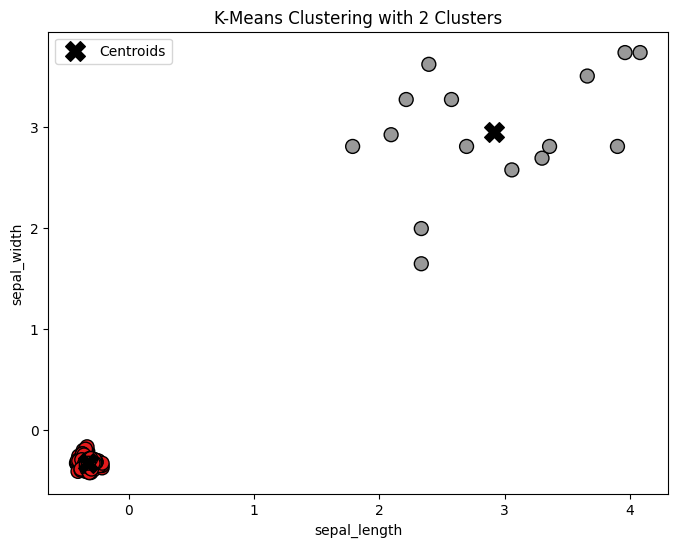

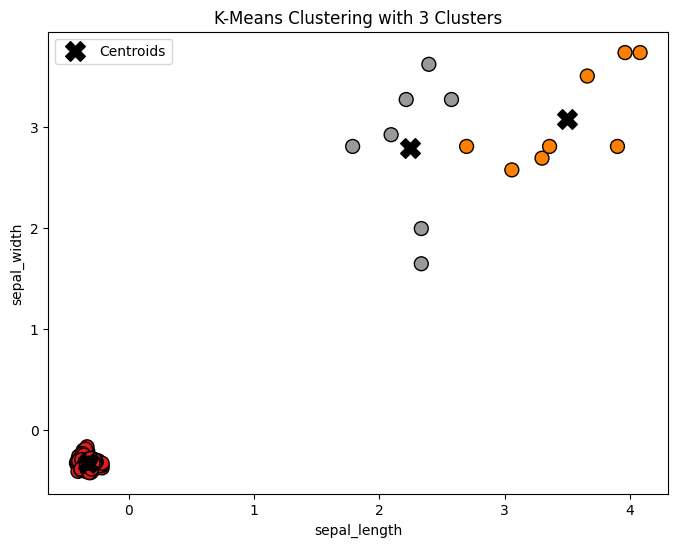

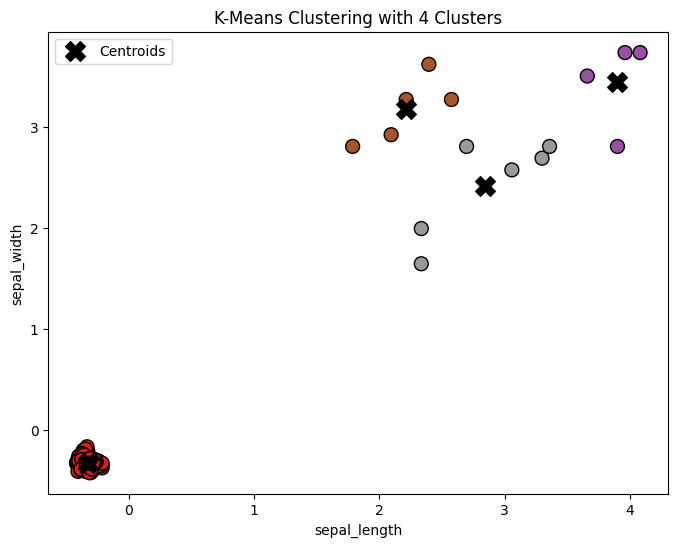

In [81]:
# 1. Siapkan fitur (X) dan label (y)
feature_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = df_merged[feature_cols].values
y = df_merged['class'].astype('category').cat.codes.values  # label dikodekan ke angka

# 2. Standarisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Fungsi untuk melakukan K-Means, plotting dan menampilkan centroid
def perform_kmeans_plot(X_scaled, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    # Centroid dari masing-masing klaster
    centroids = kmeans.cluster_centers_

    # Plotting data dan centroid
    plt.figure(figsize=(8, 6))

    # Scatter plot untuk 2 fitur pertama (sepal length & sepal width)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='Set1', marker='o', edgecolors='k', s=100)

    # Plot centroid dengan warna berbeda
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label='Centroids')

    plt.title(f"K-Means Clustering with {k} Clusters")
    plt.xlabel(feature_cols[0])
    plt.ylabel(feature_cols[1])
    plt.legend()
    plt.show()

# 4. Melakukan clustering dengan K=2, K=3, dan K=4 dan plot hasilnya
for k in [2, 3, 4]:
    perform_kmeans_plot(X_scaled, k)


## **Menghitung Inertia untuk Jumlah Cluster 2,3 dan 4**

In [82]:
# 1. Siapkan fitur (X) dan label (y)
feature_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = df_merged[feature_cols].values
y = df_merged['class'].astype('category').cat.codes.values  # label dikodekan ke angka

# 2. Standarisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Fungsi untuk menghitung inertia secara manual
def calculate_inertia_step_by_step(X_scaled, labels, centroids):
    inertia = 0
    print("Langkah-langkah perhitungan Inertia:")

    for i in range(len(X_scaled)):
        cluster = labels[i]
        distance = np.linalg.norm(X_scaled[i] - centroids[cluster]) ** 2
        inertia += distance
        print(f"Titik data {i+1} (Fitur: {X_scaled[i]}), Klaster: {cluster}, "
              f"Centroid: {centroids[cluster]}, Jarak kuadrat: {distance:.3f}, "
              f"Inertia sementara: {inertia:.3f}")

    return inertia

# 4. Fungsi untuk menjalankan KMeans dan menghitung inertia manual
def perform_kmeans(X_scaled, y, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    centroids = kmeans.cluster_centers_

    print(f"\n=== Hasil K-Means dengan {k} Klaster ===")
    print(f"Centroids (fitur hasil standarisasi):\n{centroids}")

    # Hitung inertia manual
    manual_inertia = calculate_inertia_step_by_step(X_scaled, labels, centroids)
    print(f"\nTotal Inertia Manual: {manual_inertia:.3f}")

    # Bandingkan dengan inertia dari sklearn
    sklearn_inertia = kmeans.inertia_
    print(f"Inertia dari sklearn: {sklearn_inertia:.3f}")
    print("="*50)

    return labels, centroids, manual_inertia

# 5. Jalankan untuk k=2, 3, dan 4
for k in [2, 3, 4]:
    perform_kmeans(X_scaled, y, k)



=== Hasil K-Means dengan 2 Klaster ===
Centroids (fitur hasil standarisasi):
[[-0.32411482 -0.32723468 -0.28613953 -0.26169305]
 [ 2.91703341  2.94511211  2.57525574  2.35523748]]
Langkah-langkah perhitungan Inertia:
Titik data 1 (Fitur: [-0.36768452 -0.27454238 -0.47336355 -0.49791933]), Klaster: 0, Centroid: [-0.32411482 -0.32723468 -0.28613953 -0.26169305], Jarak kuadrat: 0.096, Inertia sementara: 0.096
Titik data 2 (Fitur: [ 1.78761061  2.8056325   0.5357241  -0.07113133]), Klaster: 1, Centroid: [2.91703341 2.94511211 2.57525574 2.35523748], Jarak kuadrat: 11.342, Inertia sementara: 11.438
Titik data 3 (Fitur: [-0.39176603 -0.30941228 -0.48137218 -0.49791933]), Klaster: 0, Centroid: [-0.32411482 -0.32723468 -0.28613953 -0.26169305], Jarak kuadrat: 0.099, Inertia sementara: 11.536
Titik data 4 (Fitur: [2.09464986 2.92186551 0.61581042 0.04742089]), Klaster: 1, Centroid: [2.91703341 2.94511211 2.57525574 2.35523748], Jarak kuadrat: 9.842, Inertia sementara: 21.379
Titik data 5 (Fitu

## **Model Plotting Diagram Elbow Method**

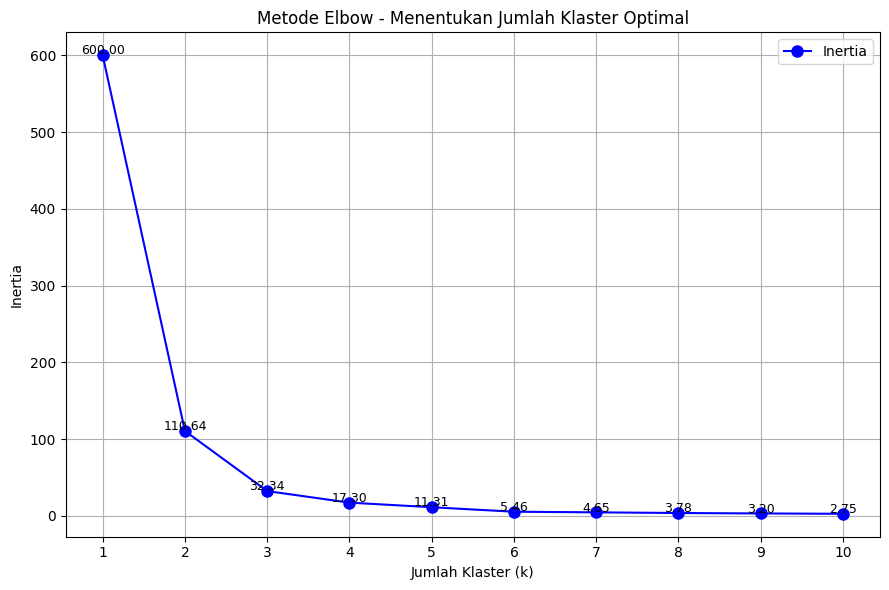

In [83]:
# 1. Siapkan fitur (X) dan label (y)
feature_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = df_merged[feature_cols].values
y = df_merged['class'].astype('category').cat.codes.values  # label dikodekan ke angka

# 2. Standarisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Hitung inertia untuk berbagai nilai k
inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# 4. Plot Elbow Diagram
plt.figure(figsize=(9, 6))
plt.plot(K_range, inertias, 'bo-', markersize=8, label='Inertia')
plt.title("Metode Elbow - Menentukan Jumlah Klaster Optimal")
plt.xlabel("Jumlah Klaster (k)")
plt.ylabel("Inertia")
plt.xticks(K_range)
plt.grid(True)

# Tambahkan label inertia di tiap titik
for i, inertia in enumerate(inertias):
    plt.text(K_range[i], inertias[i] + 1, f"{inertia:.2f}", ha='center', fontsize=9)

plt.legend()
plt.tight_layout()
plt.show()

## **Menghitung Silhouette Score untuk Jumlah Cluster 2,3 dan 4**


=== Hasil K-Means dengan 2 Klaster ===
Centroids:
[[-0.32411482 -0.32723468 -0.28613953 -0.26169305]
 [ 2.91703341  2.94511211  2.57525574  2.35523748]]
Silhouette Score untuk 2 klaster: 0.902

=== Hasil K-Means dengan 3 Klaster ===
Centroids:
[[-0.32411482 -0.32723468 -0.28613953 -0.26169305]
 [ 3.50191308  3.08168591  3.8893388   3.93000617]
 [ 2.24859951  2.78902778  1.07344654  0.55550184]]
Silhouette Score untuk 3 klaster: 0.903

=== Hasil K-Means dengan 4 Klaster ===
Centroids:
[[-0.32411482 -0.32723468 -0.28613953 -0.26169305]
 [ 3.90076309  3.44491407  4.58008332  4.67095756]
 [ 2.21385333  3.17757814  0.64784495  0.04742089]
 [ 2.84719704  2.41818912  2.84487969  2.73460459]]
Silhouette Score untuk 4 klaster: 0.904

>>> Jumlah cluster terbaik dengan dengan Silhouette Score mendekati 1 adalah k = 4 (dengan score = 0.904)


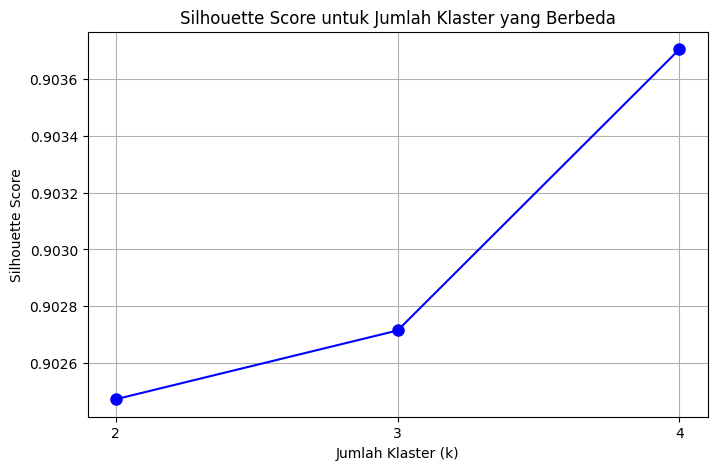

In [84]:
# 1. Siapkan fitur (X) dan label (y)
feature_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = df_merged[feature_cols].values
y = df_merged['class'].astype('category').cat.codes.values  # label dikodekan ke angka

# 2. Standarisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Fungsi untuk melakukan K-Means dan menghitung Silhouette Score
def perform_kmeans_with_silhouette(X_scaled, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    # Menghitung Silhouette Score
    silhouette_avg = silhouette_score(X_scaled, labels)

    # Centroid dari masing-masing klaster
    centroids = kmeans.cluster_centers_

    # Output hasil untuk klaster k
    print(f"\n=== Hasil K-Means dengan {k} Klaster ===")
    print(f"Centroids:\n{centroids}")
    print(f"Silhouette Score untuk {k} klaster: {silhouette_avg:.3f}")

    return silhouette_avg

# 4. Melakukan clustering dan menghitung Silhouette Score untuk k=2, 3, dan 4
silhouette_scores = []
k_values = [2, 3, 4]

for k in k_values:
    score = perform_kmeans_with_silhouette(X_scaled, k)
    silhouette_scores.append(score)

# 5. Menentukan k dengan Silhouette Score terbaik
best_k = k_values[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
print(f"\n>>> Jumlah cluster terbaik dengan dengan Silhouette Score mendekati 1 adalah k = {best_k} (dengan score = {best_score:.3f})")

# 6. Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, 'bo-', markersize=8)
plt.title("Silhouette Score untuk Jumlah Klaster yang Berbeda")
plt.xlabel("Jumlah Klaster (k)")
plt.ylabel("Silhouette Score")
plt.xticks(k_values)
plt.grid(True)
plt.show()